## Gensim Word2Vec Example
Gensim is library that contains family of algorithms, using highly optimized C routines, data streaming and Pythonic interfaces.

The word2vec algorithms include skip-gram and CBOW models, using either hierarchical softmax or negative sampling

In [3]:
!pip install gensim
!pip install nltk
!pip install kagglehub


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for kagglehub from https://files.pythonhosted.org/packages/a4/8e/4077b08b95a1f8302c694a8b399bd413815fbe89045c41e6e08cd7d9439a/kagglehub-0.3.13-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 1.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec

Go to Kaggle website and download the archive "Reviews.csv" from the dataset "Amazon Fine Food Reviews": https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

In [17]:
import pandas as pd
rev = pd.read_csv("Reviews.csv")
print(rev.head())

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

# We create the list of the words that our corpus has

In [18]:
corpus_text = 'n'.join(rev[:1000]['Text'])
data = []
# iterate through each sentence in the file
for i in sent_tokenize(corpus_text):
    temp = []
    # tokenize the sentence into words
    for j in word_tokenize(i):
        temp.append(j.lower())
    data.append(temp)

# Create the Word2Vec model with Gensim

Here's the table converted to markdown:

| Parameter | Type / Default | Meaning |
|-----------|----------------|---------|
| sentences | list of list of str | Your training data — a list where each item is a tokenized sentence (e.g. [['I', 'love', 'NLP'], ['Word2Vec', 'is', 'cool']]). |
| vector_size | int, default = 100 | Dimensionality of the word vectors (i.e., number of features in the embedding). Larger size captures more semantic nuance but requires more data and memory. |
| window | int, default = 5 | Maximum distance between the target word and its surrounding context words. A larger window means a broader context. |
| min_count | int, default = 5 | Ignores all words that appear fewer than this number of times. Helps filter out noise and rare words. |
| sg | int, default = 0 | Defines the training algorithm:• sg = 0 → CBOW (Continuous Bag of Words) — predicts the current word from context.• sg = 1 → Skip-gram — predicts context words from the current word. Skip-gram works better with smaller datasets and rare words. |
| epochs | int, default = 5 | Number of iterations (epochs) over the training corpus. Increasing can improve accuracy, but training takes longer. |
| workers | int, default = 3 | Number of CPU cores to use for training (parallelization). The higher, the faster training will be. |
| hs | int, default = 0 | If 1, hierarchical softmax is used for training; if 0, and negative > 0, then negative sampling is used instead. |
| negative | int, default = 5 | Number of negative samples to use. Setting this to 0 disables negative sampling. Works only if hs=0. |
| seed | int, optional | Random seed for reproducibility. |
| alpha | float, default = 0.025 | The initial learning rate. It decreases linearly during training. |
| min_alpha | float, default = 0.0001 | The minimum learning rate during training decay. |
| max_vocab_size | int, optional | Limits RAM during vocabulary building — if not None, truncates the vocabulary to this size. |

In [21]:
model1 = gensim.models.Word2Vec(data, min_count = 1,vector_size = 100, window = 5, sg=0)
model2 = gensim.models.Word2Vec(data, min_count = 1, vector_size = 100, window = 5, sg = 1)

In [24]:
vector = model1.wv['tuna']  # get numpy vector of a word

sims = model1.wv.most_similar('tuna', topn=10)  # get other similar words
sims

[('good', 0.9899908304214478),
 ('open', 0.9898842573165894),
 ('but', 0.9898215532302856),
 ('they', 0.9897565245628357),
 ('strong', 0.9897210001945496),
 ('taste', 0.9897156357765198),
 ('so', 0.9896429777145386),
 ('bit', 0.9896155595779419),
 ('than', 0.989595890045166),
 ('too', 0.989519476890564)]

In [25]:
vector = model2.wv['tuna']  # get numpy vector of a word

sims = model2.wv.most_similar('tuna', topn=10)  # get other similar words
sims

[('loaded', 0.9979016184806824),
 ('dark', 0.997722327709198),
 ('pineapple', 0.9975768327713013),
 ('packed', 0.997495174407959),
 ('berry', 0.9973620772361755),
 ('flat', 0.9971824288368225),
 ('heavy', 0.9971795082092285),
 ('rancid', 0.9971654415130615),
 ('caffeine', 0.9971510171890259),
 ('easier', 0.9971479177474976)]

The trained word vectors are stored in a KeyedVectors instance, as model.wv as seen above
The reason for separating the trained vectors into KeyedVectors is that if you don’t need the full model state any more (don’t need to continue training), its state can be discarded, keeping just the vectors and their keys proper.

This results in a much smaller and faster object that can be mmapped for lightning fast loading and sharing the vectors in RAM between processes:

In [29]:
from gensim.models import KeyedVectors

# Store just the words + their trained embeddings.

word_vectors = model1.wv

word_vectors.save("word2vec.wordvectors")

# Load back with memory-mapping = read-only, shared across processes.

wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')

vector = wv['computer']  # Get numpy vector of a word
vector

array([-0.01472778,  0.0125055 , -0.00509185,  0.00987635,  0.01021576,
       -0.02438146,  0.00495023,  0.01368502, -0.00784239, -0.00670052,
       -0.00625063, -0.02627889,  0.00277008,  0.01424747,  0.0033359 ,
       -0.00895101, -0.00882116, -0.00324835, -0.00260253, -0.02320874,
        0.01155806, -0.00289588,  0.00123141, -0.01916512, -0.0023807 ,
        0.00104227, -0.00812353, -0.00684614, -0.01983803,  0.00213921,
        0.00824856, -0.00447656,  0.01269457, -0.00809465,  0.00108675,
        0.01592377, -0.00398536, -0.00154602, -0.00547724, -0.00738372,
        0.01378865, -0.01898868,  0.00468487, -0.00893158,  0.02113138,
        0.00091682, -0.0186873 ,  0.00487336, -0.00228076,  0.01275709,
       -0.00327466, -0.0009361 ,  0.01317397, -0.01081174, -0.00219821,
        0.00587832,  0.00444646, -0.00244603, -0.00214767,  0.00431362,
        0.01447633, -0.01045399, -0.00278129, -0.00405764, -0.00173503,
        0.01633202,  0.00610369,  0.00404233, -0.00980323,  0.02

Code that finds the top similar words to "tuna" from your wv vectors and plots them in 2-D using PCA (deterministic and fast). It also highlights "tuna" and labels all points.

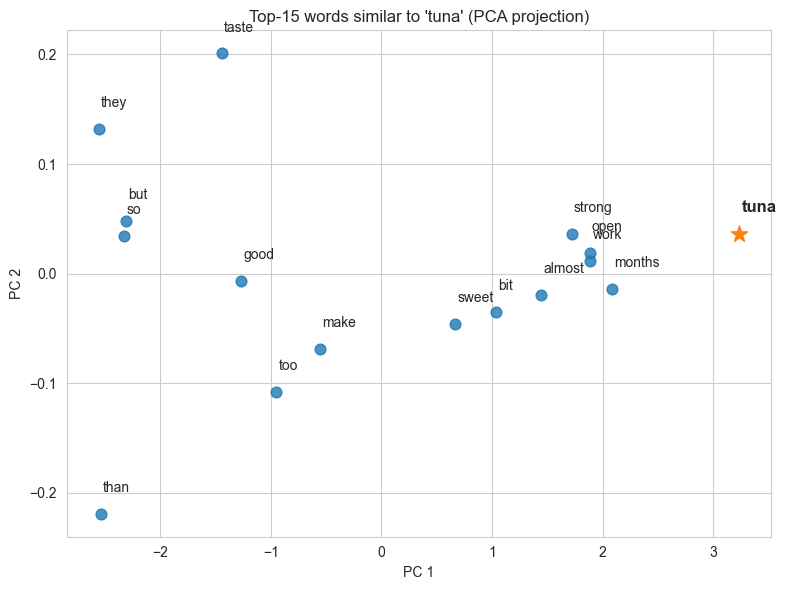

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_similar_words(wv, query="tuna", topn=15):
    # Graceful fallback for casing
    if query not in wv.key_to_index:
        if query.lower() in wv.key_to_index:
            query = query.lower()
        elif query.title() in wv.key_to_index:
            query = query.title()
        else:
            raise KeyError(f"'{query}' not in vocabulary.")

    # Get similar words
    sims = wv.most_similar(query, topn=topn)  # [(word, score), ...]
    words = [w for w, _ in sims] + [query]

    # Collect vectors
    X = np.vstack([wv[w] for w in words])

    # 2D projection
    pca = PCA(n_components=2, random_state=42)
    X2 = pca.fit_transform(X)

    # Split for styling
    query_xy = X2[-1]
    others_xy = X2[:-1]
    other_labels = words[:-1]

    plt.figure(figsize=(8, 6))
    # plot similar words
    plt.scatter(others_xy[:, 0], others_xy[:, 1], s=60, alpha=0.8)
    # plot the query word
    plt.scatter(query_xy[0], query_xy[1], s=150, marker='*')  # highlighted

    # annotate others
    for (x, y), label in zip(others_xy, other_labels):
        plt.text(x + 0.02, y + 0.02, label, fontsize=10)

    # annotate query last so it's on top
    plt.text(query_xy[0] + 0.02, query_xy[1] + 0.02, query, fontsize=12, weight="bold")

    plt.title(f"Top-{topn} words similar to '{query}' (PCA projection)")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.tight_layout()
    plt.show()


plot_similar_words(wv, query="tuna", topn=15)


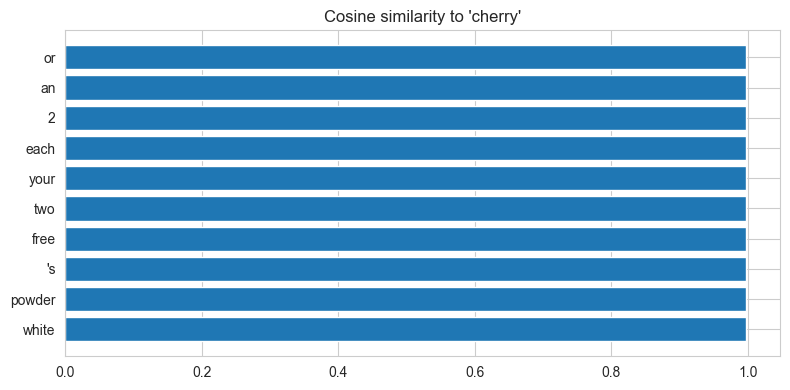

In [35]:
import matplotlib.pyplot as plt

def bar_similarities(wv, query="tuna", topn=10):
    sims = wv.most_similar(query, topn=topn)
    labels, scores = zip(*sims)
    plt.figure(figsize=(8,4))
    plt.barh(range(len(scores)), scores)
    plt.yticks(range(len(scores)), labels)
    plt.gca().invert_yaxis()
    plt.title(f"Cosine similarity to '{query}'")
    plt.tight_layout()
    plt.show()

bar_similarities(wv, "cherry")


In [38]:
# Show all available models in gensim-data

print(list(gensim.downloader.info()['models'].keys()))


['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


# Homework
1. Train Word2Vec models with different parameters (e.g., vector_size, window, sg) and compare the results.
2. Use the trained Word2Vec embeddings in a simple text classification task (e.g., sentiment analysis) and evaluate the performance.
3. Visualize the embeddings using PCA to see how similar words cluster together.

# Use trained embeddings in downstream tasks
You can use the trained Word2Vec/ Fasttext/ Glove embeddings as input features for various downstream NLP tasks such as text classification, named entity recognition, or machine translation. Here's a simple example of how to use the embeddings for text classification using a logistic regression model.

In [67]:
import re
from tqdm import tqdm
import numpy as np
from pathlib import Path


In [47]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("leadbest/googlenewsvectorsnegative300")

print("Path to dataset files:", path)

100%|██████████| 3.17G/3.17G [04:06<00:00, 13.8MB/s]

Extracting files...


Path to dataset files: /Users/bilgesipal/.cache/kagglehub/datasets/leadbest/googlenewsvectorsnegative300/versions/2


In [50]:
path

'/Users/bilgesipal/.cache/kagglehub/datasets/leadbest/googlenewsvectorsnegative300/versions/2'

In [60]:
emb_path = list(Path(path).rglob("GoogleNews-vectors-negative300.bin"))[0]
print("Embedding file:", emb_path)

Embedding file: /Users/bilgesipal/.cache/kagglehub/datasets/leadbest/googlenewsvectorsnegative300/versions/2/GoogleNews-vectors-negative300.bin


In [64]:
def load_word2vec_binary(path, limit=None):
    """Load GoogleNews .bin Word2Vec file (no gensim)."""
    with open(path, "rb") as f:
        header = f.readline()
        vocab_size, dim = map(int, header.split())
        print(f"Header: {vocab_size} words, dim={dim}")
        word_vectors = {}
        for i in tqdm(range(vocab_size if not limit else min(limit, vocab_size))):
            # Read word
            word = []
            while True:
                ch = f.read(1)
                if ch == b' ':
                    break
                if ch == b'':
                    break
                word.append(ch)
            word = b''.join(word).decode("utf-8", errors="ignore")
            # Read vector
            vec = np.frombuffer(f.read(dim * 4), dtype=np.float32)
            f.read(1)  # newline
            word_vectors[word] = vec
        return word_vectors, dim

In [65]:
#  Load limited subset for demo
w2v, dim = load_word2vec_binary(emb_path, limit=200000)
print("Loaded words:", len(w2v))

Header: 3000000 words, dim=300


100%|██████████| 200000/200000 [00:01<00:00, 190557.37it/s]

Loaded words: 152943


# The simplest representation of documents is avarage of word vectors

In [68]:
def tokenize(text):
    return re.findall(r"[A-Za-z']+", text.lower())


In [75]:
corpus_text = '\n'.join(rev.loc[:999, 'Text'].astype(str))
data = []

for i in sent_tokenize(corpus_text):
    temp = [j.lower() for j in word_tokenize(i)]
    data.append(temp)

# --- 4. Labels ---
labels = rev.loc[:999, 'Score'].astype(str).tolist()
print("Number of samples:", len(data))
print("Number of labels:", len(labels))

Number of samples: 4511
Number of labels: 1000


In [76]:
def doc_vector(tokens, w2v, dim):
    vecs = [w2v[t] for t in tokens if t in w2v]
    if not vecs:
        return np.zeros(dim)
    return np.mean(vecs, axis=0)

In [83]:
X = np.vstack([doc_vector(tokens, w2v, dim) for tokens in data[:1000]])
y = np.array(labels)

print("Feature matrix shape:", X.shape)

Feature matrix shape: (1000, 300)


In [84]:
len(y)

1000

# Example classification task

In [85]:
from sklearn.model_selection import train_test_split
#  Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y if len(set(y)) > 1 else None
)

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report


#Train logistic regression
clf = LogisticRegression(max_iter=200, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

#Evaluate
labels_for_cm = sorted(set(y_test) | set(y_pred))  # safe union of actual and predicted

print(classification_report(y_test, y_pred,
                            labels=labels_for_cm,
                            zero_division=0))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00        29
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00        23
           4       0.00      0.00      0.00        41
           5       0.64      0.99      0.78       193

    accuracy                           0.64       300
   macro avg       0.13      0.20      0.16       300
weighted avg       0.41      0.64      0.50       300

